In [1]:
print("heello")

heello


In [12]:
import os

# Define the input and output folders
input_folder = 'LSL_Models/'
output_folder = 'LSL_Models_Edited/'

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Loop through files Model_2.txt to Model_200.txt
for i in range(1000):
    file_name = f'Model_{i}.txt'
    input_path = os.path.join(input_folder, file_name)
    output_path = os.path.join(output_folder, file_name)
    
    if os.path.exists(input_path):
        with open(input_path, 'r') as infile, open(output_path, 'w') as outfile:
            for line in infile:
                # Remove the first character and write to new file
                outfile.write(line[1:])


In [ ]:
import pandas as pd
import os

# Folder where your edited txt files are located
folder_path = 'LSL_Models_Edited/'

# List to store DataFrames for each file
dataframes = []

# Loop through the files from Model_2.txt to Model_49.txt
for i in range(2, 50):  # Adjust range for desired files
    file_name = f'Model_{i}.txt'  # Construct the file name
    file_path = os.path.join(folder_path, file_name)  # Construct the full file path
    
    if os.path.exists(file_path):  # Check if the file exists
        # Read the file into a DataFrame using whitespace as delimiter
        df = pd.read_csv(file_path, delim_whitespace=True, skiprows=0)
        
        # Append the DataFrame to the list
        dataframes.append(df)
        # Uncomment the following line to print the first few rows and columns of each DataFrame
        # print(df.head(), df.columns)

# Import necessary modules for further processing
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

# Define constants and Mars' structure
R_MARS = 3389.5  # Radius of Mars in km
R_CORE = 1550.0  # Radius of the Mars' core in km
STEP_SIZE = 10.0

# Load seismic data

def get_slowness_2d(position):
    """Determine P-wave slowness based on depth in 2D."""
    global df
    dep = abs(R_MARS - np.linalg.norm(position))
    lower_row = df[df["Depth[km]"] <= dep].iloc[-1]
    vp = lower_row["Vs[km/s]"]
    return 1.0 / vp if vp > 0 else 0

def snells_angle(vector):
    y, x = vector[1], vector[0]
    a = np.arctan2(y, x)
    if abs(a) <= np.pi / 2:
        return np.pi / 2 + a
    else:
        return (a - np.pi * 3 / 2) if a > 0 else (a + np.pi / 2)

out_subtends = None

In [ ]:


def trace_ray_2d(origin, direction, max_steps=1000):
    """
    Trace the path of a seismic ray in 2D.
    Parameters:
    origin (tuple): The starting point of the ray as a tuple of (x, y) coordinates.
    direction (tuple): The initial direction of the ray as a tuple of (x, y) components.
    max_steps (int, optional): The maximum number of steps to trace the ray. Default is 1000.
    Returns:
    list: A list of tuples representing the path of the ray.
    The function simulates the propagation of a seismic ray through a 2D medium. 
    It iteratively updates the ray's position based on the local slowness and handles 
    refraction at boundaries where the slowness changes. The ray tracing stops if the 
    slowness becomes zero, the ray exits the medium (e.g., outside Mars), or the maximum 
    number of steps is reached.
    The function also checks if the ray reaches a specific radius (3300 units) and 
    sets a flag. If the ray moves beyond this radius after setting the flag, it calculates 
    the subtended angle and terminates the tracing if the angle difference is within 15 degrees.
    Note:
    - The function assumes the existence of external functions `get_slowness_2d` and 
      `snells_angle` which are used to get the slowness at a position and calculate 
      Snell's law refraction angles, respectively.
    - `STEP_SIZE` and `R_MARS` are assumed to be predefined constants.
    - `out_subtends` is assumed to be a global variable used to store the subtended angle.
    """
    """Trace the path of a seismic ray in 2D."""
    path = [origin]
    current_position = np.array(origin)
    current_radius = np.linalg.norm(current_position)
    current_direction = np.array(direction)
    flag = False

    for _ in range(max_steps):
        # Get the current slowness at the current position
        current_slowness = get_slowness_2d(current_position)
        if current_slowness == 0:
            print("Ray terminated: current_slowness == 0")
            break

        # Calculate the step distance based on the slowness
        step_distance = STEP_SIZE * (1 / (current_slowness ))
        tentative_position = current_position + step_distance * current_direction
        new_slowness = get_slowness_2d(tentative_position)

        # Break if the new slowness is zero or the position is outside Mars
        if new_slowness == 0:
            break
        if np.linalg.norm(tentative_position) > R_MARS:
            break

        # Handle refraction if the slowness changes
        if new_slowness != current_slowness:
            normal = current_position / np.linalg.norm(current_position)

            norm_angle = snells_angle(-normal)
            dir_angle = snells_angle(current_direction)
            incidence_angle = dir_angle - norm_angle
            sin_refract = (current_slowness / new_slowness) * np.sin(incidence_angle)

            # Check for valid refraction
            if -1 <= sin_refract <= 1:
                refraction_angle = np.arcsin(sin_refract) 
                # 2D rotation matrix for refraction
                
                z = (-np.cos(refraction_angle))
                y = (np.sin(refraction_angle))
                current_direction = np.array([y, z])

                current_direction /= np.linalg.norm(current_direction)


            else:
                current_direction = current_direction - 2 * np.dot(current_direction, normal) * normal


        # Update the current position and add it to the path
        current_radius = np.linalg.norm(current_position)
        current_position += step_distance * current_direction
        
        if current_radius <= 3300:
            flag = True
        global out_subtends
        if current_radius > 3300 and flag:
            a = 180 - np.rad2deg(snells_angle(vector=current_position))
            if out_subtends == 0:
                out_subtends = a
                if abs(a - out_subtends) <= 15:
                    a = max(a, out_subtends)  
            return path
        
        path.append(tuple(current_position))

    return path

# Generate ray paths in 2

def plot_mars_cutaway_with_rays_2d(raypaths, mars_radius=3389.5, core_mantle_boundary=1800.0):
    """Plots a 2D cutaway of Mars with ray paths and angle labels."""
    fig, ax = plt.subplots(figsize=(10, 10))

    # Circle for Mars' surface
    mars_circle = plt.Circle((0, 0), mars_radius, color='blue', alpha=0.3, fill=False)
    ax.add_patch(mars_circle)

    # Circle for Mars' core
    core_circle = plt.Circle((0, 0), core_mantle_boundary, color='red', alpha=0.3, linestyle='dashed', fill=False)
    ax.add_patch(core_circle)

    # Plot ray paths in distinct colors
    colors = plt.cm.viridis(np.linspace(0, 1, len(raypaths)))
    for raypath, color in zip(raypaths, colors):
        x_coords = [point[0] for point in raypath]
        z_coords = [point[1] for point in raypath] # z-coords are the second element in 2D tuples
        ax.plot(x_coords, z_coords, color=color, linewidth=1.5)

    # Add angle labels
    angles = np.arange(0, 360, 15)
    label_radius = mars_radius * 1.1  # Radius for label positions

    for angle in angles:
        angle_rad = np.deg2rad(angle)
        x_label = label_radius * np.sin(angle_rad)
        z_label = label_radius * np.cos(angle_rad)

        # Adjust text alignment based on angle to be outside the circle
        ha = 'center'
        va = 'center'
        if 0 <= angle < 90:
            ha = 'left'
            va = 'bottom'
        elif 90 <= angle < 180:
            ha = 'right'
            va = 'bottom'
        elif 180 <= angle < 270:
            ha = 'right'
            va = 'top'
        elif 270 <= angle < 360:
            ha = 'left'
            va = 'top'
        if angle == 0:
            va = 'bottom'
        if angle == 90:
            ha = 'left'
        if angle == 180:
            va = 'top'
        if angle == 270:
            ha = 'right'

        ax.text(x_label, z_label, f'{angle}°', ha=ha, va=va, fontsize=9)


    # Formatting the plot
    ax.set_xlabel("X (km)")
    ax.set_ylabel("Z (km)")
    ax.set_title("2D Cutaway of Mars with Ray Paths")
    ax.set_aspect('equal') # Ensure circles look like circles
    ax.set_xlim(-mars_radius*1.1, mars_radius*1.1)
    ax.set_ylim(-mars_radius*1.1, mars_radius*1.1)
    plt.show()

# Plot in 2D



ModuleNotFoundError: No module named 'seaborn'

In [2]:
df1 = pd.DataFrame

rawdick = []
# Find the min and max angles for each cluster
depthmodels = dataframes
for m in depthmodels:
    
    df = m
    meanvs = df['Vs[km/s]'][df['Vs[km/s]'] != 0].mean()
    stdvs = df['Vs[km/s]'][df['Vs[km/s]'] != 0].std()

    q60 = df['Vs[km/s]'].quantile(0.60)
    tmvs = df['Vs[km/s]'][df['Vs[km/s]'] >= q60].mean()

    vs0w = df[df['Vs(km/s)'] == 0]['Depth(km)'].min()


    out_subtends = 0

    origin_2d = (0, R_MARS - 10.0)
    raypaths_2d = []
    angles = [0.2 * k for k in range(0, 360)]
    
    for ang in angles:
        direction_2d = (
            np.sin(np.radians(ang)),
            -np.cos(np.radians(ang))
        )
        direction_2d = direction_2d / np.linalg.norm(direction_2d)
        raypath = trace_ray_2d(origin_2d, direction=direction_2d, max_steps=200)
       
        raypaths_2d.append(raypath)

    #plot_mars_cutaway_with_rays_2d(raypaths_2d)

    rawdick.append({'out_subtends': out_subtends,  'meanvs': meanvs,  'stdvs': stdvs, 'tmvs': tmvs, 'vs0w': vs0w})

# # Group angles by cluster



In [ ]:
# Sample DataFrame (Replace this with your actual DataFrame)

df1 = pd.DataFrame

rawdick = []
# Find the min and max angles for each cluster
depthmodels = dataframes
for m in depthmodels:
    
    df = m
    meanvs = df['Vs[km/s]'][df['Vs[km/s]'] != 0].mean()
    stdvs = df['Vs[km/s]'][df['Vs[km/s]'] != 0].std()

    q60 = df['Vs[km/s]'].quantile(0.60)
    tmvs = df['Vs[km/s]'][df['Vs[km/s]'] >= q60].mean()

    vs0w = df[df['Vs(km/s)'] == 0]['Depth(km)'].min()


    out_subtends = 0

    origin_2d = (0, R_MARS - 10.0)
    raypaths_2d = []
    angles = [0.2 * k for k in range(0, 360)]
    
    for ang in angles:
        direction_2d = (
            np.sin(np.radians(ang)),
            -np.cos(np.radians(ang))
        )
        direction_2d = direction_2d / np.linalg.norm(direction_2d)
        raypath = trace_ray_2d(origin_2d, direction=direction_2d, max_steps=200)
       
        raypaths_2d.append(raypath)

    #uncommentate below to view simulations
    #plot_mars_cutaway_with_rays_2d(raypaths_2d)

    rawdick.append({'out_subtends': out_subtends,  'meanvs': meanvs,  'stdvs': stdvs, 'tmvs': tmvs, 'vs0w': vs0w})

# # Group angles by clusters

# Sample DataFrame (Replace this with your actual DataFrame)
rawdick = pd.DataFrame(rawdick)
correlation_matrix = rawdick.corr()
import seaborn as sns
# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()
print(rawdick.head())
# Define features and target variable
X = rawdick[[ 'meanvs', 'stdvs', 'tmvs']]  # Features
y = rawdick['out_subtends']  # Target variable

# Split the dataset into training and testing sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# Display model coefficients
print("Model Coefficients:", model.coef_)
print("Model Intercept:", model.intercept_)

df1 = pd.DataFrame

rawdick = []
# Find the min and max angles for each cluster
depthmodels = dataframes
for m in depthmodels:
    
    df = m
    meanvs = df['Vs[km/s]'][df['Vs[km/s]'] != 0].mean()
    stdvs = df['Vs[km/s]'][df['Vs[km/s]'] != 0].std()

    q60 = df['Vs[km/s]'].quantile(0.60)
    tmvs = df['Vs[km/s]'][df['Vs[km/s]'] >= q60].mean()

    vs0w = df[df['Vs(km/s)'] == 0]['Depth(km)'].min()


    out_subtends = 0

    origin_2d = (0, R_MARS - 10.0)
    raypaths_2d = []
    angles = [0.2 * k for k in range(0, 360)]
    
    for ang in angles:
        direction_2d = (
            np.sin(np.radians(ang)),
            -np.cos(np.radians(ang))
        )
        direction_2d = direction_2d / np.linalg.norm(direction_2d)
        raypath = trace_ray_2d(origin_2d, direction=direction_2d, max_steps=200)
       
        raypaths_2d.append(raypath)

    #plot_mars_cutaway_with_rays_2d(raypaths_2d)

    rawdick.append({'out_subtends': out_subtends,  'meanvs': meanvs,  'stdvs': stdvs, 'tmvs': tmvs, 'vs0w': vs0w})

# # Group angles by cluster

# Sample DataFrame (Replace this with your actual DataFrame)
rawdick = pd.DataFrame(rawdick)
correlation_matrix = rawdick.corr()
import seaborn as sns
# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()
print(rawdick.head())
# Define features and target variable
X = rawdick[[ 'meanvs', 'stdvs', 'tmvs']]  # Features
y = rawdick['out_subtends']  # Target variable

# Split the dataset into training and testing sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# Display model coefficients
print("Model Coefficients:", model.coef_)
print("Model Intercept:", model.intercept_)

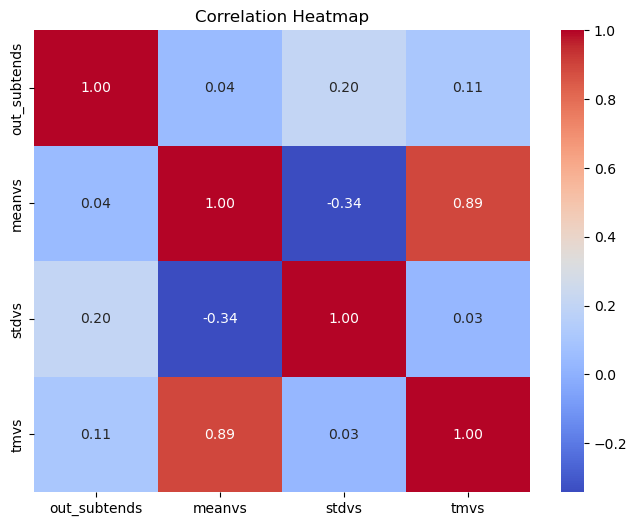

In [14]:
correlation_matrix = rawdick.corr()
# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()